<a href="https://colab.research.google.com/github/mikeguzman1294/OperationsResearch/blob/main/ILS_HubLocation_NetworkOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ILS - HUB Location **Optimization**


## Import the Dataset

In [34]:
# Clone the repo containing the dataset
!git clone -l -s https://github.com/mikeguzman1294/OperationsResearch.git cloned-repo
# Move to the relative path containing the datasets
%cd cloned-repo/Datasets

Cloning into 'cloned-repo'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 42 (delta 16), reused 7 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), done.
/content/cloned-repo/Datasets/cloned-repo/Datasets/cloned-repo/Datasets/cloned-repo/Datasets


In [35]:
# Define dataset file names
# Comment/Uncomment to switch between large and small instance datasets

INPUT_DATA = 'InputDataHubSmallInstance.xlsx'  # Small instance
#INPUT_DATA = 'InputDataHubLargeInstance.xlsx'  # Large instance

## Imports of modules

Import some modules necessary to make this code work properly.

In [36]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import random

## Definitions of constants

Define some constants needed in the meta-heuristic.

In [37]:
# ILS parameters

ALPHA = 0.05       # defines the ratio in which a worse explored perturbated solution can be set as a next step
MAX_ITER = 400     # maximum number of iterations (Stopping criterion of ILS)
MAX_ITER_NI = 200   # number of iterations without improvement of the objective function (Stopping criterion of ILS)
MAX_ITER_LS = 5    # maximum number of iterations of the local search operator (Outer loop)
MAX_SWAPS = 1      # maximum number of swaps of the local search operator (Inner loop) - NOT USED
NB_SWAPS = 8       # number of swaps in the perturbation operator - NOT USED
OBJECTIVE_SMALL = 6794788.65    # value of deterministic solution for small dataset obtained through MILP model

## Functions to load and prepare the data

In the cell below, two functions are defined: 

- first, `read_excel_data`, which returns the values of a specific sheet in an Excel file,
- then, `create_data_model` which fills the `data` dictionary with the data from the various sheets of the Excel file, as well as some dependent data, which is calculated from the raw data.

In [38]:
def read_excel_data(filename, sheet_name):
    data = pd.read_excel(filename, sheet_name=sheet_name, header=None)
    values = data.values
    return values


def create_data_model():
    data = {}
    # This section contains all required data #
    node_num = read_excel_data(INPUT_DATA, "NodeNum")
    data['node_num'] = node_num[0][0]

    # Flow between Nodes Read From Excel #
    data['flow'] = read_excel_data(INPUT_DATA, "flow(wij)")

    # Cost between Nodes Read from Excel #
    data['var_cost'] = read_excel_data(INPUT_DATA, "varCost(cij)")

    # Fixed Location Cost Read from Excel #
    data['fix_cost'] = read_excel_data(INPUT_DATA, "fixCost(fk)")

    # Discount Factor Read from Excel #
    data['alpha'] = read_excel_data(INPUT_DATA, "alpha")

    # Discount Factor Read from Excel #
    data['cap'] = read_excel_data(INPUT_DATA, "Cap(ckmax)")

    # Dependent Parameters
    data['origin'] = data['flow'].sum(axis=1)
    data['destination'] = data['flow'].sum(axis=0)

    return data

## Functions to calculate the objective function from the solution representation

The cell below contains 2 functions to calculate the objective function of an individual: 
- first `prufer_to_tree` which transforms the Prüfer representation of a solution into a tree, 
- second, `compute_of` which calculates the fitness (or objective function) of an individual (or a solution).

In [39]:
def prufer_to_tree(a):
    """Transform the Prüfer representation into a tree."""
    tree = []
    t = range(0, len(a)+2)

    # the degree of each node is how many times it appears
    # in the sequence
    deg = [1]*len(t)
    for i in a:
        deg[i] += 1

    # for each node label i in a, find the first node j with degree 1 and add
    # the edge (j, i) to the tree
    for i in a:
        for j in t:
            if deg[j] == 1:
                tree.append((i, j))
                # decrement the degrees of i and j
                deg[i] -= 1
                deg[j] -= 1
                break

    last = [x for x in t if deg[x] == 1]
    tree.append((last[0], last[1]))

    return tree


def compute_of(individual, data):
    """Calculate the objective function of the individual."""
    fitness = 100000000

    tree_edges = prufer_to_tree(individual)

    graph = nx.Graph(tree_edges)
    all_pairs_path = dict(nx.all_pairs_shortest_path(graph))

    hubs = np.unique(individual)
    fixed_cost = data['fix_cost'][hubs].sum()

    variable_cost = 0
    flow_to_hub = np.zeros(data['node_num'])
    for i in range(data['node_num']):
        for j in range(data['node_num']):
            if j > i:
                for x in range(len(all_pairs_path[i][j]) - 1):
                    route = all_pairs_path[i][j]
                    if route[x] in hubs and route[x + 1] in hubs:
                        variable_cost = variable_cost + data['alpha'] * data['var_cost'][route[x], route[x + 1]] * (data['flow'][i, j] + data['flow'][j, i])
                    else:
                        variable_cost = variable_cost + data['var_cost'][route[x], route[x + 1]] * (data['flow'][i, j] + data['flow'][j, i])

        fitness = fixed_cost + variable_cost[0]

    # Calculating the Entering flow to Each Hub #
    for i in range(len(tree_edges)):
        if tree_edges[i][0] not in hubs:
            flow_to_hub[tree_edges[i][1]] = flow_to_hub[tree_edges[i][1]] + (data['origin'][tree_edges[i][0]] + data['destination'][tree_edges[i][0]])
        elif tree_edges[i][1] not in hubs:
            flow_to_hub[tree_edges[i][0]] = flow_to_hub[tree_edges[i][0]] + (data['origin'][tree_edges[i][1]] + data['destination'][tree_edges[i][1]])
    for i in range(len(hubs)):
        flow_to_hub[hubs[i]] = flow_to_hub[hubs[i]] + (data['origin'][hubs[i]] + data['destination'][hubs[i]])

    # Feasibility Check: Capacity Constraint #
    exceed = np.subtract(data['cap'], flow_to_hub)
    exceed_cap = exceed[hubs, hubs]
    if min(exceed_cap) < 0:
        fitness = np.dot(fitness, 100000000)

    return fitness

## Functions to create solutions or individuals

The cell below contains two functions regarding individuals:

- first, `generate_individual` to create a random individual, 
- second, `initial_solution` which returns this single randomly generated individual and its fitness.

In [40]:
def generate_individual(node_num):
    """Generate a random individual."""
    individual = np.ndarray.tolist(np.random.randint(low=0, high=node_num-1, size=node_num-2, dtype='int'))
    
    return individual

def initial_solution(data):
    """Generate a solution and calculate its objective function."""
    solution = []

    # Here we are generating only one initial solution
    solution.append(generate_individual(data['node_num']))

    value_of = compute_of(solution[0], data)

    return solution, value_of

## Functions for the local search

Below functions to perform a local search can be found: 
- first the general high-level `local_search` function,
- second the `reverse` function, which implements a swap operator, 
- third the `reverse_neighborhood` function which generates the neighborhood based on the reverse operator,
- and finally the `unique_pairs` function, used by `swap_neighborhood`, wich generates unique pairs indexes. 

In [41]:
# This function is for the local search operator

def local_search(of, sol, data):
    """Perform a local search."""
    # number of iterations local search
    nb_iterations = 0

    # Make a explicit copy to avoid pass by reference
    best_of = of
    best_sol = sol.copy()

    # Main loop local search
    # Local search operators is repeated MAX_ITER_LS times
    while nb_iterations <= MAX_ITER_LS:

        nb_iterations += 1

        # Use of operator to perform local search        
        best_of, best_sol = reverse_neighborhood(best_sol, best_of, data)

    return best_of, best_sol

# The following function is a sub-function to do a single reversion move on the solution (i.e., reversing the order of elements between positions p1 and p2)

def reverse(p1, p2, parent):
    
    """Reversion operator."""
    
    # List slicing is used to reverse the given interval of the list
    reverse_part = parent[p1:p2+1][::-1]
    
    return parent[:p1] + reverse_part + parent[p2+1:]

# The following function is a function to generate the neighbours of the given solution "sol"
# NOTE: A single reversion will create a neighbour
# All pairs or MAX_SWAPS number of possible reversion moves are investigated

def reverse_neighborhood(solution, best_of, data):
    
    """Neighborhood generation with a reversion operator."""
    
    # Make a explicit copy to avoid pass by reference
    sol = solution.copy()
    best_sol = sol

    for p1, p2 in unique_pairs(len(sol)):
      n = reverse(p1, p2, sol)
      # Compute the fitness of the current neighbor
      n_fitness = compute_of(n, data)
      if n_fitness < best_of:
        best_of = n_fitness
        best_sol = n      

    return best_of, best_sol


def unique_pairs(n):
    """Produce pairs of indexes in range(n)"""
    for i in range(n):
        for j in range(i + 1, n):
            yield i, j

## Functions for the perturbation of solutions

In [42]:
# This is an auxiliary function to generate a 2-tuple, which abstracts a perturbation operation.
# A perturbation operation is composed of:
#   1) an index of a digit to be replaced in the solution
#   2) a digit to replace the given element of the solution

def perturbation_tuple(sol):
  
  # Generate a random index between 0 and lenght-of-prufer-code -1
  index = random.randint(0,len(sol)-1)
  # Generate a random digit between 0 and number-of-nodes -1
  number = random.randint(0,len(sol)+1)

  # Loop to ensure replacement digit and digit to be replaced are not equal
  while sol[index] == number:
    number = random.randint(0,len(sol)+1)  

  return index, number


# The following function is a sub-function to do a single prufer digit replacement 
# (i.e., changing the element at the given index with a distinct valid number)

def replacement(index, number, sol):
  
  sol[index] = number

  return sol


# The following function is a sub-function to do the element replacement perturbation

def random_replacement(sol):

  # Generate a pertubation operation
  index, number = perturbation_tuple(sol)

  # Check history to verify this perturbation operation has not been done on the current step yet
  # If the perturbation has already been done, generate a new perturbation operation
  while (index, number) in perturbation_set:
    index, number = perturbation_tuple(sol)

  # Perform the replacement with a valid perturbation operator
  sol = replacement(index, number, sol)

  # Add the perturbation operation to the history record (set-hashing-structure)
  perturbation_set.add((index, number))

  return sol
  

# This function is the main body of the perturbation operator, wherein the random_replacement function is called

def perturb(solution, data):
    
    sol = solution.copy()
    # Generate a perturbated solution
    pert_sol = random_replacement(sol)
    # Compute the fitness of the perturbated solution
    pert_of = compute_of(pert_sol, data)

    return pert_of, pert_sol

## ILS Main Scripts


Random solution
Initial objective function value: [1.1210713e+15]
Solution: [[2, 3, 1, 4, 0, 0]]

Local Search
Objective function value: [8.32628895e+14]
Tour: [0, 1, 2, 0, 4, 3]


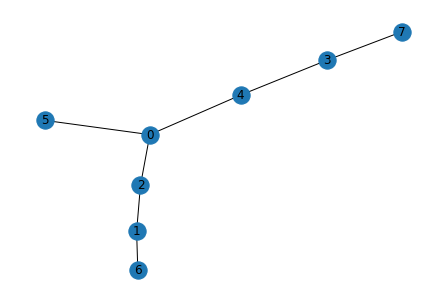

In [43]:
# *************************Initialisation***************************
# Initialise the data
data = create_data_model()

# Find initial solution (just one) with a constructive heuristic
best_sol, best_of = initial_solution(data)

# ********************************************************************

print("Random solution")
print("Initial objective function value:", best_of)
print("Solution:", best_sol)

# **************************Local Search******************************

best_of, best_sol = local_search(best_of, best_sol[0], data)
best_known = best_sol
best_of_known = best_of

print("\nLocal Search")
print("Objective function value:", best_of)
print("Tour:", best_sol)

# Draw the initial solution local minimum prufer code's phenotype (spanning tree)
best_solution = prufer_to_tree(best_sol)
graph = nx.Graph(best_solution)
plt.figure(2)
nx.draw(graph, with_labels=True)
plt.show()


ILS iteration number: 0
Current Global Best Solution: [0, 1, 2, 0, 4, 3]
Perturbation History Set Status:
set()
Best sol at end of local search of perturbated sol: [8.0927415e+14] -> [2, 3, 0, 3, 4, 0]

ILS iteration number: 1
Current Global Best Solution: [2, 3, 0, 3, 4, 0]
Perturbation History Set Status:
set()
Best sol at end of local search of perturbated sol: [8.47035345e+14] -> [3, 1, 2, 3, 4, 0]

ILS iteration number: 2
Current Global Best Solution: [2, 3, 0, 3, 4, 0]
Perturbation History Set Status:
set()
Best sol at end of local search of perturbated sol: [8.371037e+14] -> [2, 3, 7, 3, 4, 0]

ILS iteration number: 3
Current Global Best Solution: [2, 3, 0, 3, 4, 0]
Perturbation History Set Status:
set()
Best sol at end of local search of perturbated sol: [10154589.25] -> [5, 0, 2, 3, 3, 7]

ILS iteration number: 4
Current Global Best Solution: [5, 0, 2, 3, 3, 7]
Perturbation History Set Status:
set()
Best sol at end of local search of perturbated sol: [10200284.55] -> [7, 0, 4

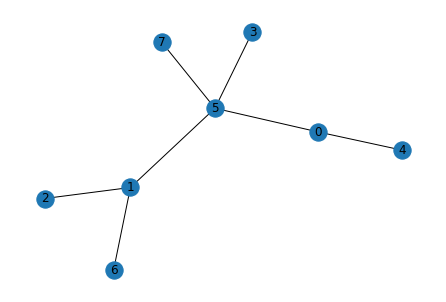

In [44]:
# ********************************************************************
# ******************************ILS***********************************
flag_continue = True
improve = 0

 # Initialize number of iterations of ILS
nb_iterations = 0
# Variable to avoid an infinite loop in case maximum possible number of perturbations per unique solution is reached
nb_perturbations = 0

# Declare and initialize a global empty set to store perturbation operations history
perturbation_set = set()

# Define a limit for 1-digit replacement perturbations per best solution
max_perturbations = (data['node_num']-1) * (data['node_num']-2) 

while flag_continue and nb_iterations <= MAX_ITER and improve <= MAX_ITER_NI and nb_perturbations < max_perturbations:

    print(f'\nILS iteration number: {nb_iterations}')
    print(f'Current Global Best Solution: {best_known}')

    nb_iterations += 1
    # ******************Perturbation**********************************
    print('Perturbation History Set Status:')
    print(perturbation_set)
    pert_of, pert_sol = perturb(best_sol, data)
    nb_perturbations += 1
    # print(pert_of)

    # ******************Local Search***********************************
    best_of_pert, best_sol_pert = local_search(pert_of, pert_sol, data)
    print(f'Best sol at end of local search of perturbated sol: {best_of_pert} -> {best_sol_pert}')
    
    # ******************Aceptance criterion***************************
    if best_of_pert < best_of_known:
        best_known = best_sol_pert
        best_of_known = best_of_pert
        improve = 0        
    else:
        improve += 1        

    # Could accept a worse solution as a new starting point with an alpha margin
    if best_of_pert < best_of * (1 + ALPHA):
        best_of = best_of_pert
        best_sol = best_sol_pert
        # Clear the perturbation history if a new best solution is found after perturbation
        perturbation_set.clear()
        nb_perturbations = 0
    # else:
    #     flag_continue = False

# Print final ILS results
# print(f'Flag {flag_continue}')
print("\n")
print("After", nb_iterations, " ILS iterations, the best solution is:")
print(best_known)
print("with total cost:", best_of_known)

# If testing with the small dataset, an accuracy score against MILP solution can be computed
if data['node_num'] == 8:
  accuracy = ( OBJECTIVE_SMALL / best_of_known ) * 100
  print(f'\nPercentage of accuracy against MILP solution is: {accuracy} percent.')

# Draw the ILS solution prufer code's phenotype (spanning tree)
best_solution = prufer_to_tree(best_known)
graph = nx.Graph(best_solution)
plt.figure(2)
nx.draw(graph, with_labels=True)
plt.show()